## Smoothing and thresholding relation - tests

In [247]:
from src.distance_measures import analyse_video, analyse_image
from src.gaussian_noise import generate_noise_array, generate_noise
from src.preprocessing import process_image, process_video
from src.gradient_descent import find_default_params
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tqdm import tqdm
from skimage import filters
from skimage.morphology import label
from skimage.measure import regionprops
import statistics
from scipy.stats import percentileofscore

### 4-step process to generate synthetic data

In [ ]:
plt.rcParams['image.cmap'] = 'gray'

fig, ax = plt.subplots(1,4, figsize=(20,15))

im = np.random.normal(size=(200, 200))

noise1 = im
noise2 = filters.gaussian(im, 2)
noise3 = filters.gaussian(im, 1) > (0.1)
noise4 = label(filters.gaussian(im, 3) > (0.1))

ax[0].set_title(r'1. Normal distributed noise, X $\sim \mathcal{N}(0,1)$')
ax[0].imshow((noise1))
ax[1].set_title(r'Gaussian smoothing applied, $\alpha = 2$')
ax[1].imshow((noise2))
ax[2].set_title(r'Thresholding, $\tau = 0.1$ applied')
ax[2].imshow((noise3))
ax[3].set_title(r'Labeling applied')
ax[3].imshow(label2rgb(noise3))


### Varying smoothing parameter while keeping threshold constant

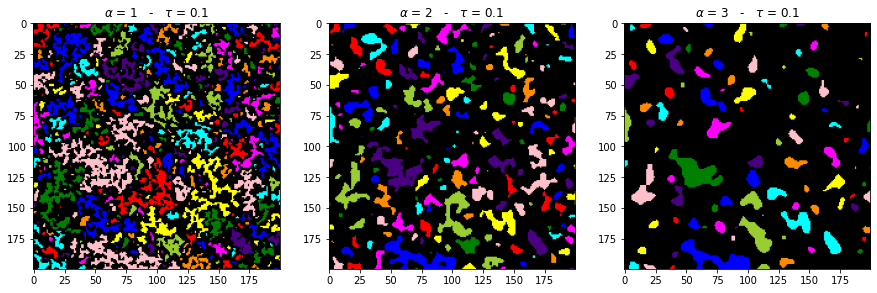

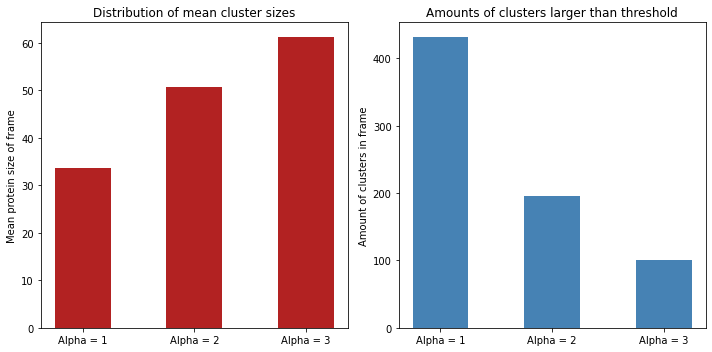

In [244]:
fig, ax = plt.subplots(1,3, figsize=(15,10))

im = np.random.normal(size=(200, 200))

noise1 = label(filters.gaussian(im, 1) > (0.1))
noise2 = label(filters.gaussian(im, 2) > (0.1))
noise3 = label(filters.gaussian(im, 3) > (0.1))

ax[0].set_title(r'$\alpha$ = 1   -   $\tau$ = 0.1')
ax[0].imshow(label2rgb(noise1))
ax[1].set_title(r'$\alpha$ = 2   -   $\tau$ = 0.1')
ax[1].imshow(label2rgb(noise2))
ax[2].set_title(r'$\alpha$ = 3   -   $\tau$ = 0.1')
ax[2].imshow(label2rgb(noise3))

fig1,ax1 = plt.subplots(1,2,figsize=(10,5))
means_gaus = np.zeros(3)
amounts_gaus = np.zeros(3)
gauss = [noise1, noise2, noise3]
for i in range(3):
    gaus_regions = regionprops(gauss[i])
    for gaus_region in gaus_regions:
        means_gaus[i] = means_gaus[i] + gaus_region.area
    means_gaus[i] = means_gaus[i] / len(gaus_regions)
    amounts_gaus[i] = len(gaus_regions)

X = ['Alpha = 1','Alpha = 2','Alpha = 3']
X_axis = np.arange(len(X))
ax1[0].bar(X_axis, means_gaus, 0.5, color='firebrick')
ax1[0].set_xticks(X_axis, X)
ax1[0].set_ylabel("Mean protein size of frame")
ax1[0].set_title("Distribution of mean cluster sizes")

ax1[1].bar(X_axis, amounts_gaus, 0.5, color='steelblue')
ax1[1].set_xticks(X_axis, X)
ax1[1].set_ylabel("Amount of clusters in frame")
ax1[1].set_title("Amounts of clusters larger than threshold")

plt.tight_layout()
plt.show()

### Interrelation of smoothing parameter and thresholding

In [248]:
#Calculate what percentile 0.1 is at different smoothing levels
g1_ = []
g2_ = []
g3_ = []

for i in range(1000):
    im = np.random.normal(size=(200, 200))
    g1_.append(percentileofscore(np.sort(filters.gaussian(im,1).flatten()),0.1))
    g2_.append(percentileofscore(np.sort(filters.gaussian(im,2).flatten()),0.1))
    g3_.append(percentileofscore(np.sort(filters.gaussian(im,3).flatten()),0.1))

print(statistics.mean(g1_),statistics.mean(g2_),statistics.mean(g3_))

63.750745 75.7117875 84.85907


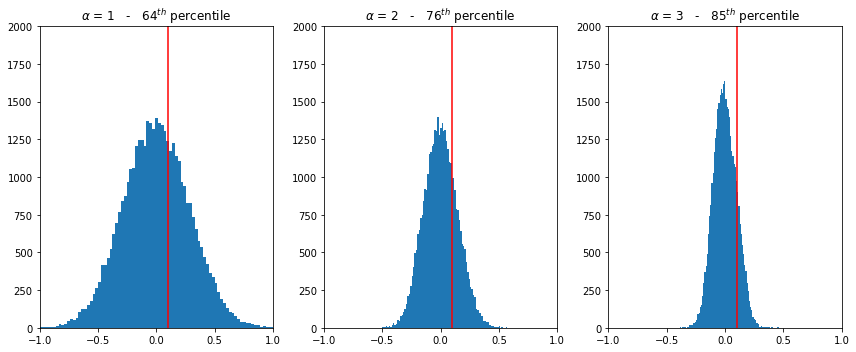

In [254]:
fig, ax = plt.subplots(1,3, figsize=(12,5))

ax[0].set_title(r'$\alpha$ = 1   -   $64^{th}$ percentile')
ax[0].hist(filters.gaussian(im,1).flatten(),100)
ax[0].plot([0.1, 0.1], [0, 2000], 'r-')

ax[0].set_xlim(-1,1)
ax[0].set_ylim(0,2000)

ax[1].set_title(r'$\alpha$ = 2   -   $76^{th}$ percentile')
ax[1].hist(filters.gaussian(im,2).flatten(),100)
ax[1].plot([0.1, 0.1], [0, 2000], 'r-')
ax[1].set_xlim(-1,1)
ax[1].set_ylim(0,2000)

ax[2].set_title(r'$\alpha$ = 3   -   $85^{th}$ percentile')
ax[2].hist(filters.gaussian(im,3).flatten(),100)
ax[2].plot([0.1, 0.1], [0, 2000], 'r-')
ax[2].set_xlim(-1,1)
ax[2].set_ylim(0,2000)

plt.tight_layout()
plt.show()

In [ ]:
def generate_poly(siz=800, percentile=80, degree=4):
    im = np.random.normal(size=(siz, siz))
    conf_interval_lower=[]

    for i in np.linspace(1,3,30):
        imFilt = filters.gaussian(im, i)
        conf_interval_lower.append(np.percentile(imFilt,(percentile)))

    x=np.linspace(1,3,30)
    y_lower=conf_interval_lower
    coefficients_lower = np.polyfit(x, y_lower, degree)
    polynomial_lower = np.poly1d(coefficients_lower)

    return polynomial_lower

0.09448162014124944 0.048602616958515754 0.0329862888809766


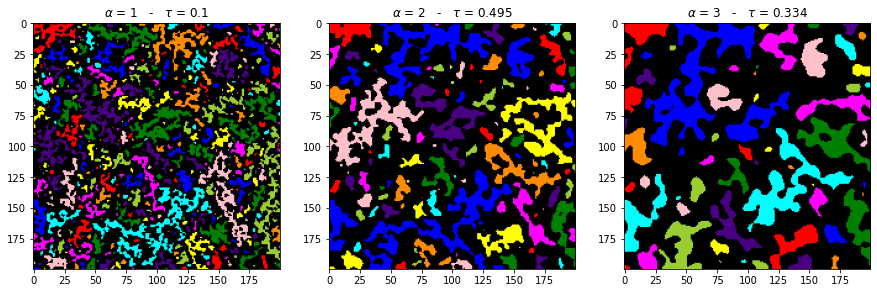

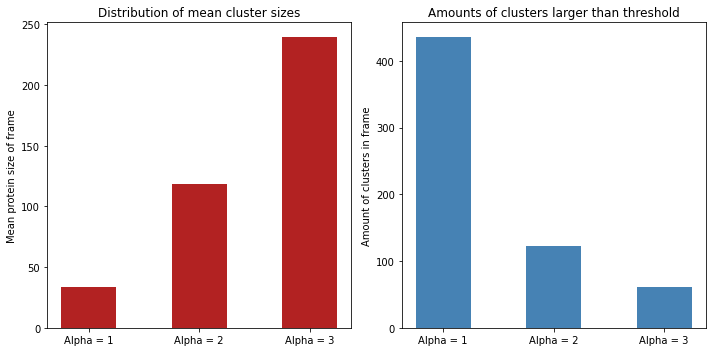

In [256]:
polyFun = generate_poly(percentile=63)

fig, ax = plt.subplots(1,3, figsize=(15,10))

im = np.random.normal(size=(200, 200))

noise1 = label(filters.gaussian(im, 1) > polyFun(1))
noise2 = label(filters.gaussian(im, 2) > polyFun(2))
noise3 = label(filters.gaussian(im, 3) > polyFun(3))

print(polyFun(1),polyFun(2),polyFun(3))

ax[0].set_title(r'$\alpha$ = 1   -   $\tau$ = 0.1')
ax[0].imshow(label2rgb(noise1))
ax[1].set_title(r'$\alpha$ = 2   -   $\tau$ = 0.495')
ax[1].imshow(label2rgb(noise2))
ax[2].set_title(r'$\alpha$ = 3   -   $\tau$ = 0.334')
ax[2].imshow(label2rgb(noise3))

fig1,ax1 = plt.subplots(1,2,figsize=(10,5))
means_gaus = np.zeros(3)
amounts_gaus = np.zeros(3)
gauss = [noise1, noise2, noise3]
for i in range(3):
    gaus_regions = regionprops(gauss[i])
    for gaus_region in gaus_regions:
        means_gaus[i] = means_gaus[i] + gaus_region.area
    means_gaus[i] = means_gaus[i] / len(gaus_regions)
    amounts_gaus[i] = len(gaus_regions)

X = ['Alpha = 1','Alpha = 2','Alpha = 3']
X_axis = np.arange(len(X))
ax1[0].bar(X_axis, means_gaus, 0.5, color='firebrick')
ax1[0].set_xticks(X_axis, X)
ax1[0].set_ylabel("Mean protein size of frame")
ax1[0].set_title("Distribution of mean cluster sizes")

ax1[1].bar(X_axis, amounts_gaus, 0.5, color='steelblue')
ax1[1].set_xticks(X_axis, X)
ax1[1].set_ylabel("Amount of clusters in frame")
ax1[1].set_title("Amounts of clusters larger than threshold")


plt.tight_layout()
plt.show()
